In [ ]:
import zipfile
# path='dogs-vs-cats.zip'
# ex_p="."
# with zipfile.ZipFile(path, 'r') as zipp:
#     zipp.extractall(ex_p)

In [ ]:
#train_path = "test1.zip"
train_path = "train.zip"

t_files = "."
tr_files = "."


with zipfile.ZipFile(train_path, 'r') as zipp:
    zipp.extractall(tr_files)

# with zipfile.ZipFile(test_path, 'r') as zipp:
#     zipp.extractall(t_files)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
#neural network
from keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2,DenseNet121,VGG16
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization
#callbacks and learning rate
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [ ]:
#image properties
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [ ]:

image_dir = "./train"

filenames = os.listdir(image_dir)
labels = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})

data.head()

,filename,label
0,dog.10956.jpg,dog
1,cat.171.jpg,cat
2,dog.6524.jpg,dog
3,dog.7302.jpg,dog
4,dog.2391.jpg,dog


In [ ]:
len(data)

25000

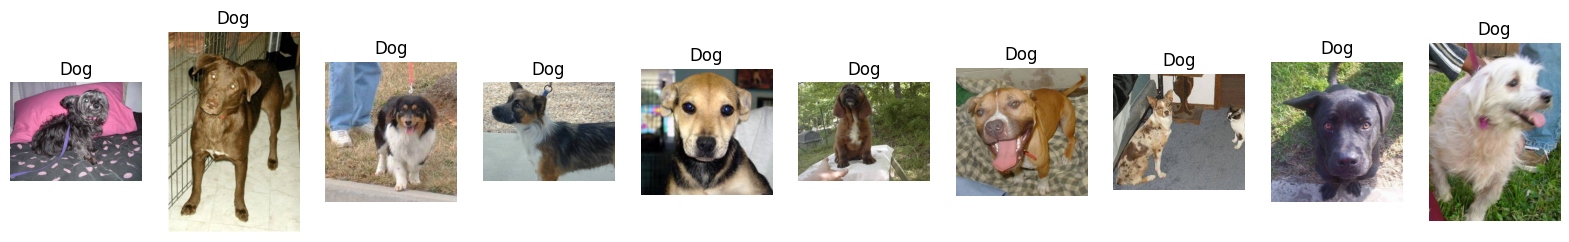

In [ ]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(10):

    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    filename = 'train/' + 'dog.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Dog',fontsize=12)
    plt.axis('off')

plt.show()

In [ ]:
labels = data['label']

X_train, X_temp = train_test_split(data, test_size=0.2, stratify=labels, random_state = 42)

label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

train_df = X_train.reset_index(drop=True)
validate_df = X_temp.reset_index(drop=True)
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

The shape of train data (20000, 2)
The shape of test data (2500, 2)
The shape of validation data (2500, 2)


In [ ]:
batch_size=15
#data generation
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )

train_generator = train_datagen.flow_from_dataframe(X_train,
                                                 "./train/",x_col='filename',y_col='label',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

validation_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)
validation_generator = validation_datagen.flow_from_dataframe(
    X_val,
    "./train/",
    x_col='filename',
    y_col='label',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)

test_generator = test_datagen.flow_from_dataframe(X_test,
                                                   directory = 'train/',
                                                   x_col= 'filename',
                                                   y_col= 'label',
                                                   batch_size = batch_size,
                                                   target_size = Image_Size,
                                                   shuffle=False
                                                  )



Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
base_model = MobileNetV2(input_shape=(Image_Width,Image_Height,Image_Channels),
                          include_top=False,
                          weights='imagenet')
base_model.trainable = True

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,681,536 (6.41 MB)

 Non-trainable params: 576,448 (2.20 MB)

In [ ]:
for layer in base_model.layers[:-80]:
  print(layer)
  layer.trainable = False

<InputLayer name=input_layer_8, built=True>
<Conv2D name=Conv1, built=True>
<BatchNormalization name=bn_Conv1, built=True>
<ReLU name=Conv1_relu, built=True>
<DepthwiseConv2D name=expanded_conv_depthwise, built=True>
<BatchNormalization name=expanded_conv_depthwise_BN, built=True>
<ReLU name=expanded_conv_depthwise_relu, built=True>
<Conv2D name=expanded_conv_project, built=True>
<BatchNormalization name=expanded_conv_project_BN, built=True>
<Conv2D name=block_1_expand, built=True>
<BatchNormalization name=block_1_expand_BN, built=True>
<ReLU name=block_1_expand_relu, built=True>
<ZeroPadding2D name=block_1_pad, built=True>
<DepthwiseConv2D name=block_1_depthwise, built=True>
<BatchNormalization name=block_1_depthwise_BN, built=True>
<ReLU name=block_1_depthwise_relu, built=True>
<Conv2D name=block_1_project, built=True>
<BatchNormalization name=block_1_project_BN, built=True>
<Conv2D name=block_2_expand, built=True>
<BatchNormalization name=block_2_expand_BN, built=True>
<ReLU name=bl

In [ ]:


# # un Freeze the base model
# base_model.trainable = True

#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(Image_Width,Image_Height,Image_Channels))
# base_model.trainable = False

#base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(Image_Width,Image_Height,Image_Channels))

#base_model.summary()
# for layer in base_model.layers[:-10]:  # Freeze all layers except last 30 layers
#     layer.trainable = False

model=Sequential()
model.add(base_model)


model.add(Conv2D(32,(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256,(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(2,activation='sigmoid'))



In [ ]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 4, 4, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 2, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 1, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 0, 0, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 0, 0, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 0, 0, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 0, 0, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 0, 0, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 0, 0, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 0)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │         1,02

 Total params: 3,019,682 (11.52 MB)

 Trainable params: 2,441,250 (9.31 MB)

 Non-trainable params: 578,432 (2.21 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam,RMSprop

optimizer1 = RMSprop(learning_rate=0.0001)

optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',
  optimizer=optimizer,metrics=['accuracy'])

In [ ]:

# earlystop = EarlyStopping(patience = 10)
# learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)



learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss',
                                             patience=2,
                                             factor=0.5,
                                             min_lr = 0.00000001,
                                             verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 19,restore_best_weights=True,verbose=0)
callbacks = [early_stoping,learning_rate_reduction]

In [ ]:
#training
epochs=40
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    #validation_steps=total_validate//batch_size,
    #steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
# steps_per_epoch = len(train_generator),
# validation_steps = len(val_generaotor),

Epoch 1/40
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 159s 106ms/step - accuracy: 0.9046 - loss: 0.2448 - val_accuracy: 0.9308 - val_loss: 0.1996 - learning_rate: 1.0000e-04
Epoch 2/40
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 129s 97ms/step - accuracy: 0.9516 - loss: 0.1243 - val_accuracy: 0.9424 - val_loss: 0.1557 - learning_rate: 1.0000e-04
Epoch 3/40
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 135s 101ms/step - accuracy: 0.9619 - loss: 0.0973 - val_accuracy: 0.9404 - val_loss: 0.1805 - learning_rate: 1.0000e-04
Epoch 4/40
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 128s 96ms/step - accuracy: 0.9679 - loss: 0.0800 - val_accuracy: 0.9616 - val_loss: 0.1111 - learning_rate: 1.0000e-04
Epoch 5/40
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 135s 101ms/step - accuracy: 0.9703 - loss: 0.0815 - val_accuracy: 0.9648 - val_loss: 0.1027 - learning_rate: 1.0000e-04
Epoch 6/40
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 128s 96ms/step - accuracy: 0.9774 - loss: 0.0647 - val_accuracy: 0.9504 - val_loss: 0.1242 - learning_rate: 1.0000e-04
Epoch 7/40
1334/1334 ━━━━━━━━━━

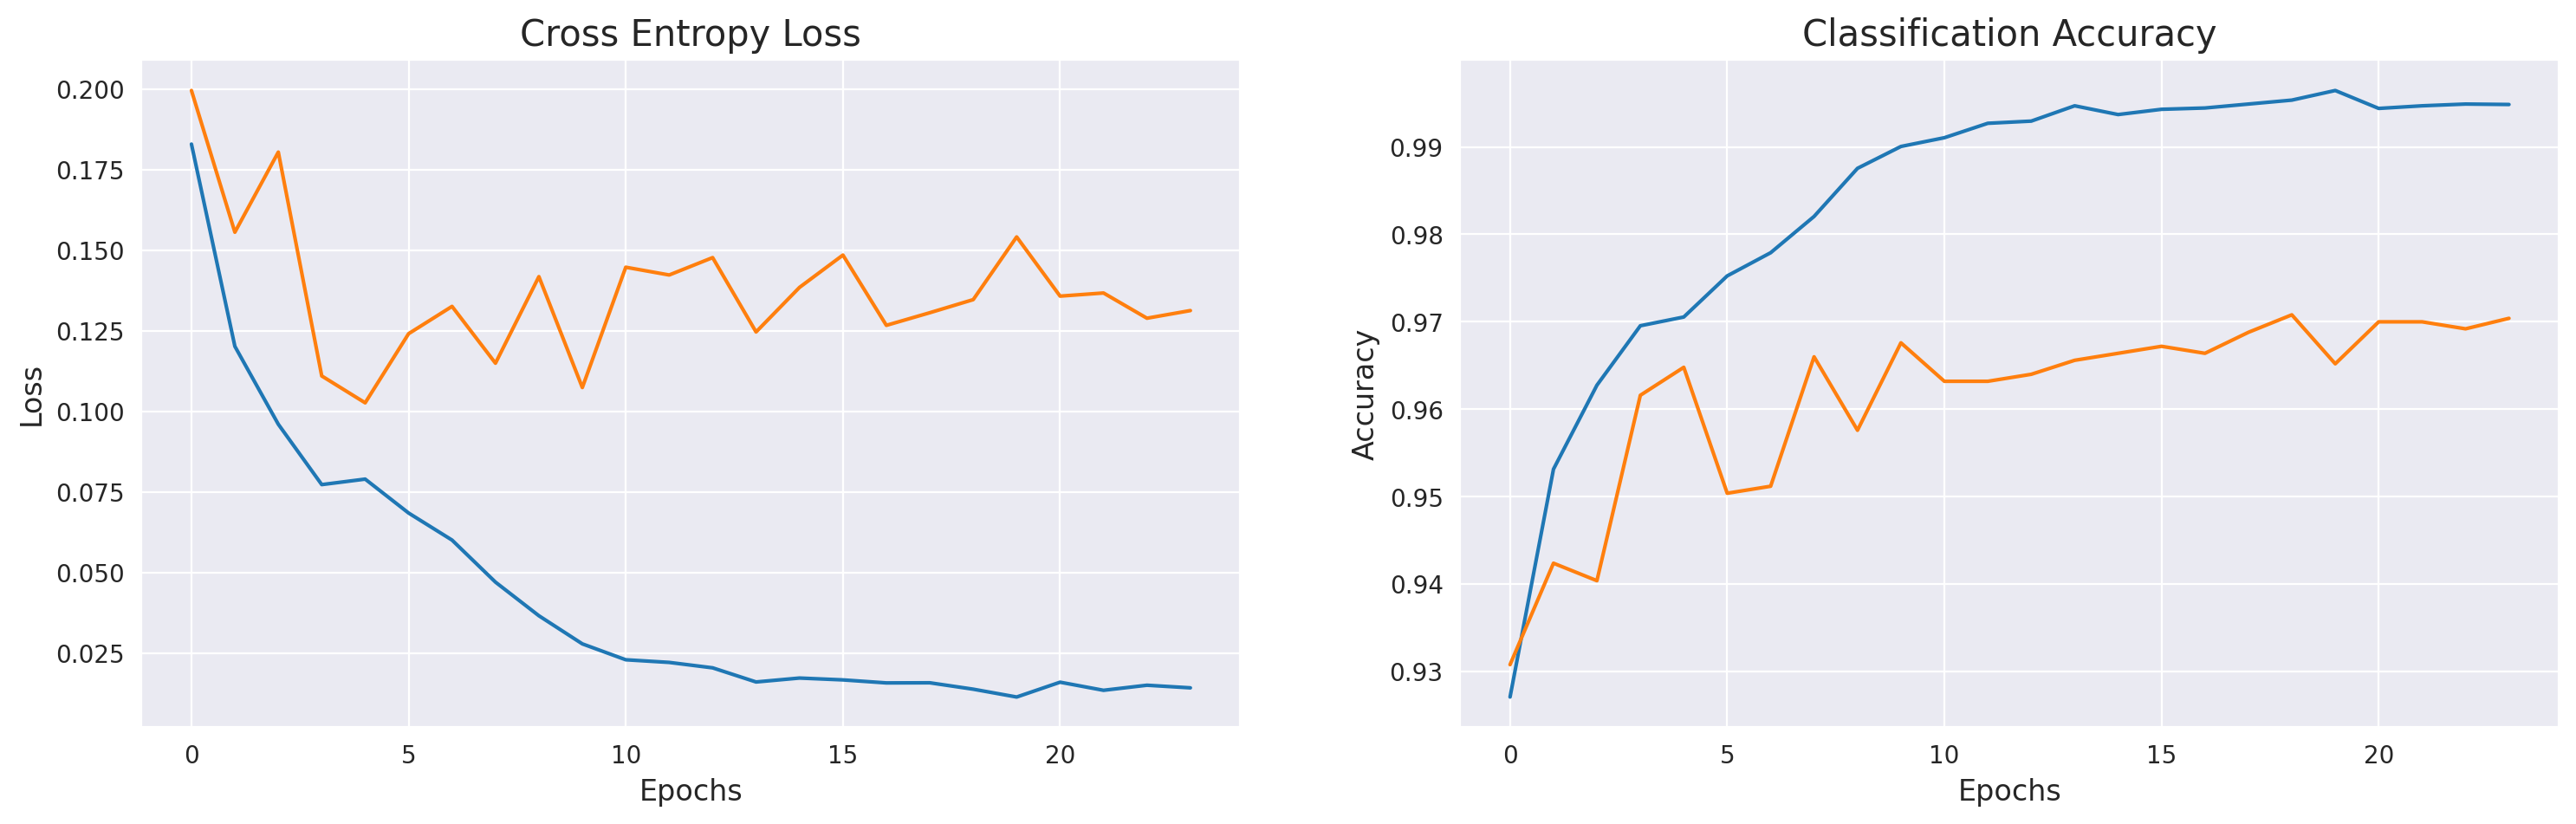

In [ ]:
# plots for accuracy and Loss with epochs
import seaborn as sns
error = pd.DataFrame(history.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [ ]:
# Save the Model
model.save("model96False.h5")

#to load
#Model=keras.models.load_model("model.h5").

In [ ]:
# Evaluvate for train generator
# loss,acc = model.evaluate(train_generator,batch_size = batch_size, verbose = 0)

# print('The accuracy of the model for training data is:',acc*100)
# print('The Loss of the model for training data is:',loss)

#Evaluvate for validation generator
loss,acc = model.evaluate(validation_generator,batch_size = batch_size, verbose = 2)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

167/167 - 13s - 79ms/step - accuracy: 0.9620 - loss: 0.1183
The accuracy of the model for validation data is: 96.20000123977661
The Loss of the model for validation data is: 0.11834903806447983


In [ ]:
# Save the Model
#model.save("model.h5")

#to load
#Model=keras.models.load_model("model.h5").

In [ ]:
# prediction
result = model.predict(test_generator,batch_size = batch_size,verbose = 0)

In [ ]:
result

array([[6.8026041e-03, 9.9294960e-01],
       [2.1073216e-05, 9.9997914e-01],
       [7.3341902e-13, 1.0000000e+00],
       ...,
       [5.4659129e-05, 9.9994528e-01],
       [7.6967401e-05, 9.9991870e-01],
       [1.7806702e-05, 9.9998164e-01]], dtype=float32)

In [ ]:


y_pred = np.argmax(result, axis = 1)

y_true = test_generator.labels

# Evaluvate
loss,acc = model.evaluate(test_generator, batch_size = batch_size, verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 95.99999785423279
The Loss of the model for testing data is: 0.10469185560941696


In [ ]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
labels =['Cat','Dog']
print(classification_report(y_true, y_pred,target_names=labels))

              precision    recall  f1-score   support

         Cat       0.98      0.95      0.96      1250
         Dog       0.95      0.98      0.96      1250

    accuracy                           0.96      2500
   macro avg       0.96      0.96      0.96      2500
weighted avg       0.96      0.96      0.96      2500



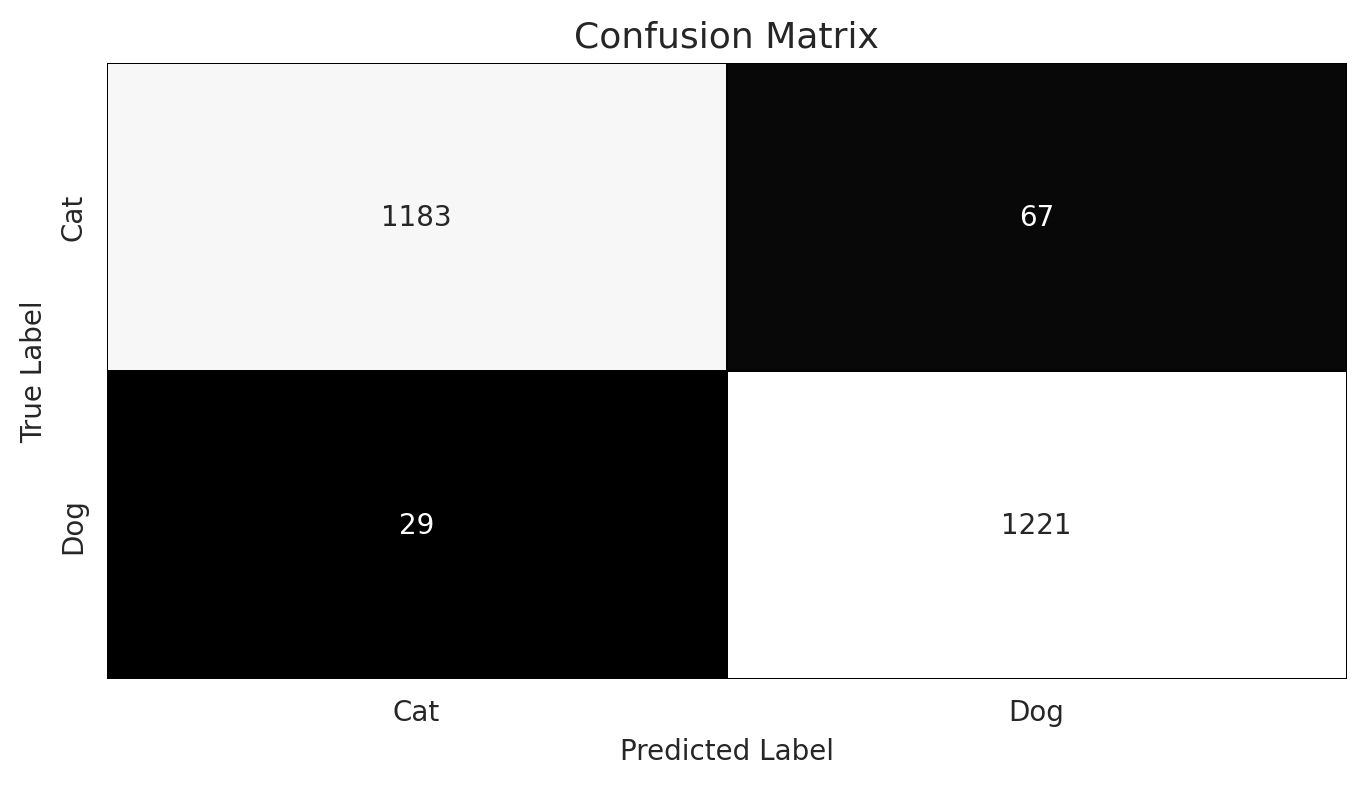

In [ ]:
confusion_mtx = confusion_matrix(y_true,y_pred)

f,ax = plt.subplots(figsize = (8,4),dpi=200)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax,cbar=False, xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label",fontsize=10)
plt.ylabel("True Label",fontsize=10)
plt.title("Confusion Matrix",fontsize=13)

plt.show()